# Image Clean-up

Images taken straight from the scanner need to be cleaned before further processing. This helps remove any unnecessary information that may influence our processing (and results!).

Here we will discuss two key clean-up operations:

1. Intensity normalisation (bias correction)
2. Brain extraction



In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting

## Dataset

Here we will be using a subset of [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI Collection from [OpenNeuro](https://openneuro.org/datasets/ds002790/versions/2.0.0).

The anatomical data along with the processed derivatives are conveninetly organized in BIDS format! 

We have already downloaded data for 'sub-0001' in the data/AOMIC directory. This includes processing run by [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/fswiki), a freely available and widely used neuroimaging tool.



## Local paths

### The root data directory tree

In [106]:
%%bash
ls ../data/AOMIC/

README
README.md
derivatives
participants.json
participants.tsv
sub-0001


### Derivatives (i.e. processed data)

Lets look into the freesurfer processing for our sub-0001

In [107]:
%%bash
ls ../data/AOMIC/derivatives/freesurfer/sub-0001/

additional
mri
stats
surf


There are 3 folders:
1. mri: preprocessed MRI volume and segmentations
2. stats: statistics generated by FreeSurfer
3. surf: surfaces generated by FreeSurfer follow the folding of the cortical grey matter

## Set Up Data Paths

In [108]:
# if you started jupyter notebook in the git repository, this should be the path to the data
local_data_dir = '../data/'

# this is where the mri processing from freesurfer was saved
freesurfer_output_dir = local_data_dir + 'AOMIC/derivatives/freesurfer/sub-0001/mri/'


## Image Clean-up Tasks

The image cleanup tasks have already been processed in the dataset we downloaded. These often use neuroimaging packages that specialise in these in these operations.

We will be using data that has been cleaned using a popular neuroimaging software package called [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeSurferWiki).


## 1. Bias correction

The magnetic field in an MRI scanner can vary beyond what we originally expect. This can be due to an uneven magnetic field across the brain (also known as inhomogeneity), variations in how the scanner receives energy (the signal) and the interaction between the magnetic field and human body.

This creates a **bias field** which causes a smooth signal intensity variation within tissue. This means that the intensities at each voxel may not necessarily relate to the underlying tissue properties!

It is important to correct for this bias field before further processing to ensure it doesn't impact our results.

<img src=../fig/N4_bias.jpeg alt="Drawing" align="middle" width="500px"/>

## Using precomputed FreeSurfer output

### Compare the original and corrected images

### Files used:
- orig.mgz: input (raw) T1 image
- nu.mgz: [Output](https://surfer.nmr.mgh.harvard.edu/fswiki/nuintensitycor) of non-parametric Non-uniform intensity Normalization (N3)

A note on **.mgz** files:
- FreeSurfer uses a slightly different format when working with images. These are not in NIfTI format. Many packages can still plot .mgz files. See [FreeSurfer's guide](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/MghFormat) for more information.

In [109]:
# first state the data from freesurfer outputs
T1_orig = freesurfer_output_dir + 'orig.mgz'
T1_corrected = freesurfer_output_dir + 'nu.mgz'

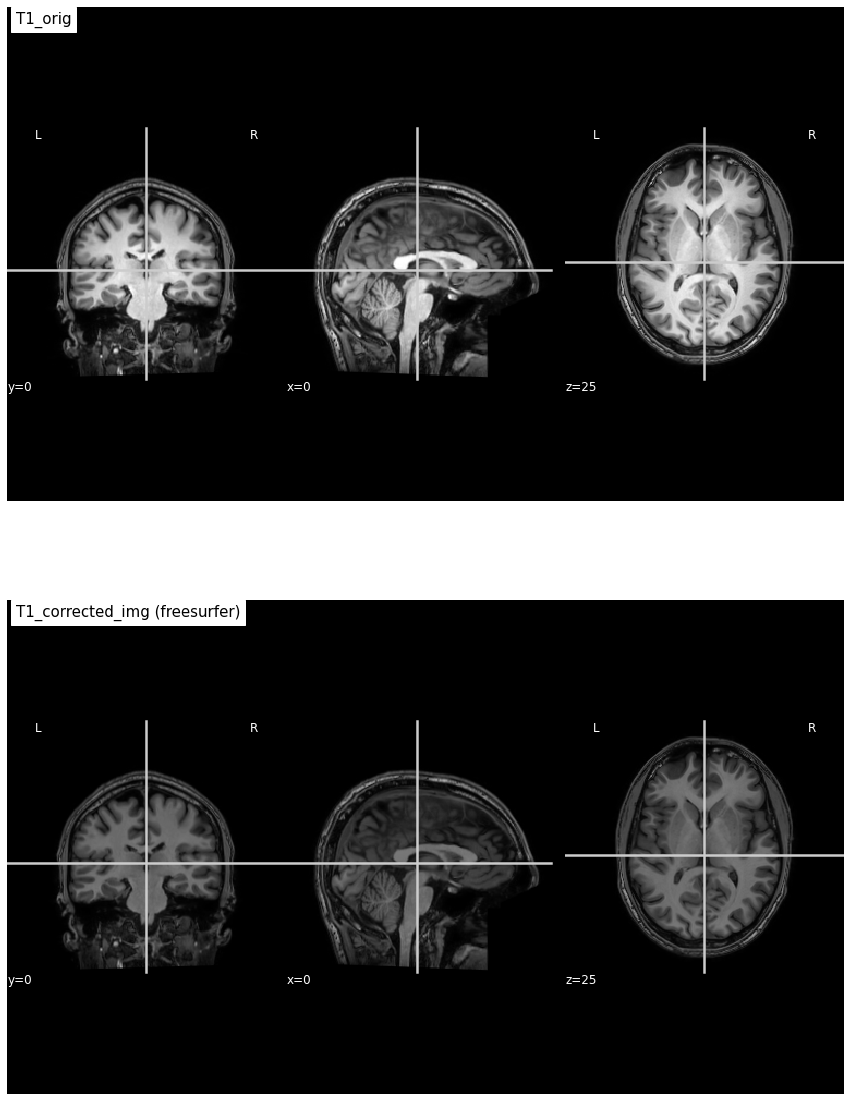

In [110]:
# now lets plot original and two following corrections of the bias field
cut_coords = (0,0,25)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,20))

plotting.plot_anat(T1_orig, title="T1_orig", cut_coords = cut_coords, vmax=255, axes=ax1)
plotting.plot_anat(T1_corrected, title="T1_corrected_img (freesurfer)", cut_coords=cut_coords, vmax=255, axes=ax2)

## Plot intensity histogram

Remember, we want to infer biological properties from voxel intensities. Bias field correction should remove unwanted variation in voxel intensities that come from non-biological sources.

Lets see how the voxel intensities change before and after bias correction.

In [111]:
# use nibabel to load and get data (notice all in one line)
T1_data_orig = nib.load(T1_orig).get_fdata()
T1_data_corrected = nib.load(T1_corrected).get_fdata()

# check the shape
T1_data_orig.shape


(256, 256, 256)

Our image also includes lots of zeros, we aren't interested in these and do not want to plot them. 

Can you use indexing to only keep voxels that do not equal 1?


Solution

In [112]:
# keep voxels where their intensity is not zero
T1_data_orig_nonzero = T1_data_orig[T1_data_orig != 0]
print('Maximum voxel intensity:', np.min(T1_data_orig_nonzero))

Maximum voxel intensity: 1.0


Handily, this also *flattens* the 3 dimensional image into 1 dimension (1 row of data) to allow for plotting.

In [121]:
print('Shape:', T1_data_orig_nonzero.shape)

Shape: (4120599,)


Can you do the same for the bias corrected T1 data from FreeSurfer?

Solution

In [114]:
T1_data_corrected_nonzero = T1_data_corrected[T1_data_corrected != 0]
print('Maximum voxel intensity:', np.min(T1_data_corrected_nonzero))
print('Shape:',T1_data_corrected_nonzero.shape)


Maximum voxel intensity: 1.0
Shape: (3854718,)


Now lets plot a histogram of all the voxel intensities in our original and bias corrected images.

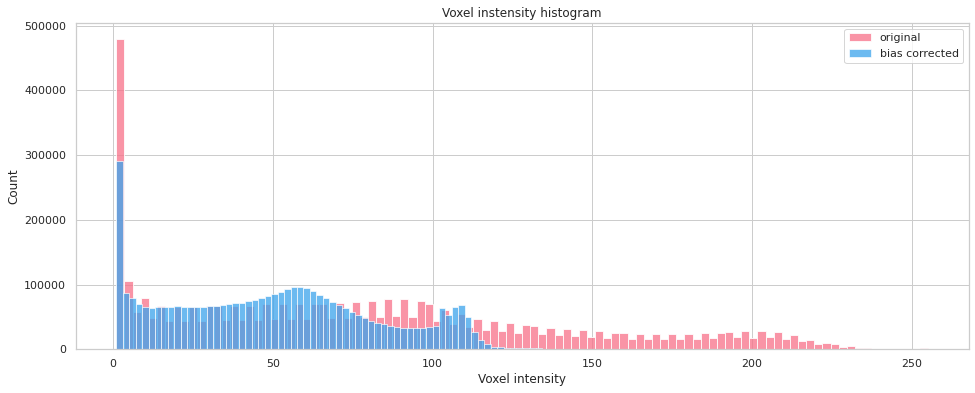

In [115]:
# seaborn (sns) is a package similar to matplotlib that makes nice looking plots

# set options for the plot
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
palette = sns.color_palette("husl", 3)

# using this axis style
with sns.axes_style("whitegrid"):
    
    # set up figure
    plt.figure(figsize=(16, 6))
    
    # plot 2 histograms overlaying each other
    g = sns.histplot(T1_data_orig_nonzero, bins=100, kde=False, color=palette[0], label='original')
    g = sns.histplot(T1_data_corrected_nonzero, bins=100, kde=False, color=palette[2], label='bias corrected')
    
    # add legend
    plt.legend()
    # add x label
    plt.xlabel('Voxel intensity')
    # add title
    plt.title('Voxel instensity histogram')

The voxel intensities clearly differ before and after bias correction.

Some peaks are visible in the bias corrected histogram. What could these represent?

## 2. Brain extraction

Brain images include the scalp, dura matter, fat, skin, muscles, eyes and bone. We are often not interested in these structures and want to remove them before further analysis.

This helps our processing focus on brain tissue of interest and reduces the chance of it accidentally including non-brain tissue as brain tissue. 

A brain mask is typically a binary image (1s or 0s) that defines which voxels contain brain. This is often used to skull strip and make sure you do not include any non-brain structures in your analysis.

FreeSurfer outputs a brain mask, but this is already the skull stripped brain. Lets take a step backwards and see how brain extraction is typically done.

We have provided a binarised brain mask to illustrate how brain extraction is here:

`../data/AOMIC/derivatives/freesurfer/sub-0001/additional/binarised_mask.nii.gz`

In [116]:
T1_brain_mask_img = nib.load('../data/AOMIC/derivatives/freesurfer/sub-0001/additional/binarised_mask.nii.gz')
T1_brain_mask_data = brain_mask_img.get_fdata()

Lets have a look at the corrected T1 image from before and this brain mask

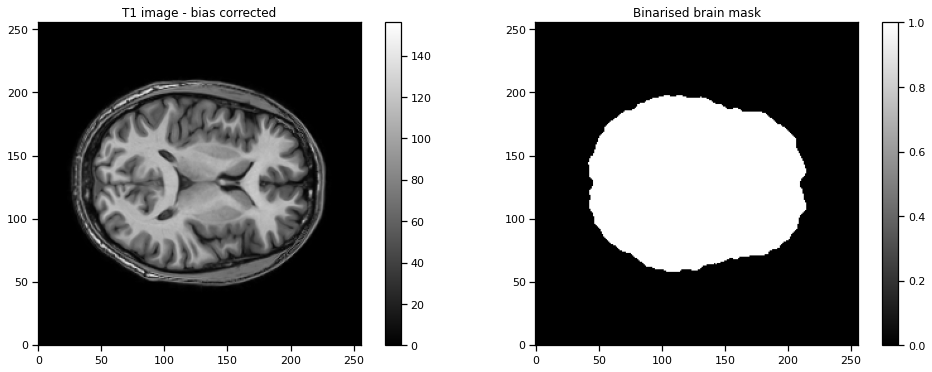

In [117]:
plt.figure(figsize=(14, 10))

# plot the T1 image
plt.subplot(2, 2, 1)
plt.imshow(T1_data_corrected[:, 140, :], origin="lower", cmap="gray")
plt.title('T1 image - bias corrected')
plt.colorbar();

# Plot binarised brian mask
plt.subplot(2, 2, 2)
plt.imshow(T1_brain_mask_data[:, 140, :], origin="lower", cmap="gray")
plt.title('Binarised brain mask')
plt.colorbar();
plt.tight_layout() # Magic command to optimize the multiple plots layout

The brain mask (right) is has the value `1` for every voxel that corresponds to the brain (note difference in range of values between plots).

We can use indexing to extract the brain from the skull using the brain mask.

**However**, this time we want to preserves the 3D shape of the t1 image. The `np.where` function from the `numpy` package can help with this.

In [118]:
# the command means:
# at each voxel in T1_brain_mask_data that equals 1, 
    # assign the value from the original brain image (T1_data_corrected) to the new array (T1_brain_data) 
    # otherwise leave it as 0
T1_brain_data = np.where(T1_brain_mask_data == 1, T1_data_corrected, 0)

Lets update our plot above to see what brain extraction did!

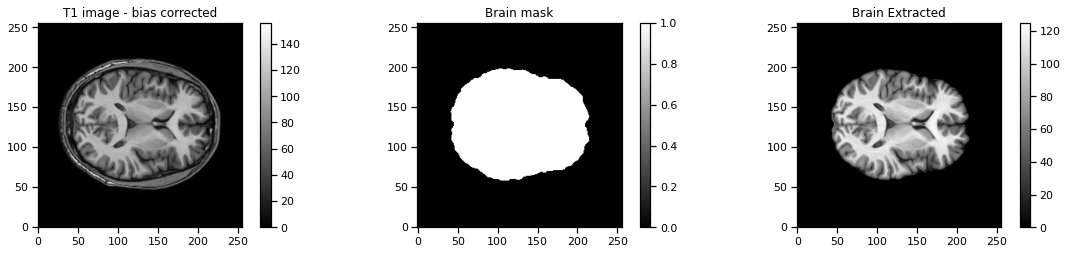

In [119]:
plt.figure(figsize=(16, 10))

# plot the T1 image
plt.subplot(3, 3, 1)
plt.imshow(T1_data_corrected[:, 140, :], origin="lower", cmap="gray")
plt.title('T1 image - bias corrected')
plt.colorbar();

# Plot binarised brian mask
plt.subplot(3, 3, 2)
plt.imshow(T1_brain_mask_data[:, 140, :], origin="lower", cmap="gray")
plt.title('Brain mask')
plt.colorbar();

# plot brain extracted image
plt.subplot(3, 3, 3)
plt.imshow(T1_brain_data[:, 140, :], origin="lower", cmap="gray")
plt.title('Brain Extracted')
plt.colorbar();
plt.tight_layout() # Magic command to optimize the multiple plots layout




### Challenge
Can you plot the voxel intensity histograms of the images before and after brain extraction?

Solution

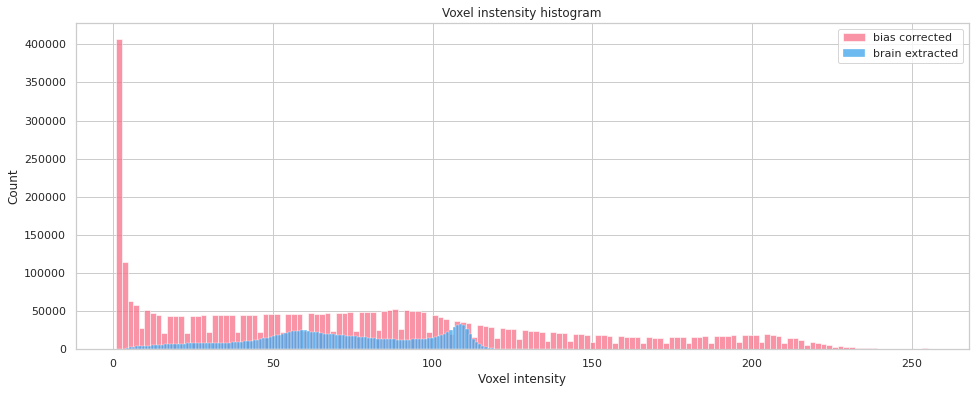

In [120]:
# select only non-zero voxels in 1-dimension as before
T1_brain_data_nonzero = T1_brain_data[T1_brain_data != 0]

# set options for the plot
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
palette = sns.color_palette("husl", 3)

# using this axis style
with sns.axes_style("whitegrid"):
    
    # set up figure
    plt.figure(figsize=(16, 6))
    
    # plot 2 histograms overlaying each other
    g = sns.histplot(T1_data_orig_nonzero, bins=144, kde=False, color=palette[0], label='bias corrected')
    g = sns.histplot(T1_brain_data_nonzero, bins=144, kde=False, color=palette[2], label='brain extracted')
    
    # add legend
    plt.legend()
    # add x label
    plt.xlabel('Voxel intensity')
    # add title
    plt.title('Voxel instensity histogram')

Based on the relaxation properties and signal intensities in a T1w image. Which tissue type do you think each peak represents in the brain extracted histogram?